### Statistické testování


* co je to nulová a alternativní hypotéza
* oboustranná alternativní hypotéza
* pravo/levostranná alternativní hypotéza
* testovací statistika
* standardní chyba testovací statistiky
* postup při realizaci testu: 1. zvolení testu, $H_0$, $H_1$, testovací statistika, výsledek
* t-rozdělení
* jednovýběrový z-test pro průměr
* jednovýběrový t-test pro průměr
* p-hodnota
* chyba I. a II. druhu, 
* spolehlivost/významnost/síla testu

Než se pustíme do statistických testů, podíváme se na speciální případ normálního rozložení. Jak víme z centrální limitní věty, výběrové statistiky začnou nabývat normálního rozložení a my můžeme použít výběrovou směrodatnou odchylku $s$ jako odhad populační směrodatné odchylky (kterou většinou neznáme). Co když se ale náš výběr skládá ze 3 pozorování? Můžeme stále použít směrodatnou odchylku těchto 3 pozorování jako odhad populační? Asi cítíme, že pokud je počet pozorování v našem výběru malý, bude i náš odhad méně přesný. Tato skutečnost je zohledněna v *t rozložení*, které je vlastně speciálním typem normálního rozložení. Jako parametry má stále průměr $mu$ a směrodatnou odchylku $sigma$, ale je tu ještě další parametr, stupně volnosti $\nu$ (degrees of freedom). Stupně volnosti rozložení se počítají jako $\nu = n-1$. Čím menší počet stupňů volnosti, tím je rozložení více rozplácnuto do stran. To odpovídá menší jistotě o tom, jakých hodnot bude naše náhodná proměnná nabývat. Pojďme si ukázat jak se liší od normálního rozložení.

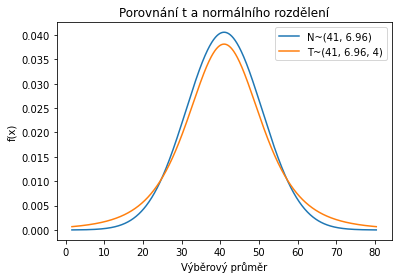

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

prumer = 41
smerodatna_odchylka = 22
n = 5
smerodatna_chyba = smerodatna_odchylka / np.sqrt(n)

x = np.linspace(prumer - 4*smerodatna_chyba, prumer + 4*smerodatna_chyba, num = 1000)
pdf_n = stats.norm.pdf(x, loc = prumer, scale = smerodatna_chyba)
pdf_df4 = stats.t.pdf(x, loc = prumer, scale = smerodatna_chyba, df = n-1)

plt.plot(x, pdf_n, label = "N~(41, 6.96)")
plt.plot(x, pdf_df4, label = f"T~(41, 6.96, {n-1})")

plt.xlabel("Výběrový průměr")
plt.ylabel("f(x)")
plt.title("Porovnání t a normálního rozdělení")
plt.legend()
plt.show()

To tedy znamená, že vetší procento případů se nachází na levé a pravé straně rozložení. Pokud bychom měli pro příklad nahoře vypočítat interval spolehlivosti na hladině spolehlivosti 89%, nahradíme ve vzorečku $IS_{0.89} = \overline{x} +/- z \frac{s}{\sqrt{n}}$ hodnotu $z$ za hodnotu $t$, tedy $IS_{0.89} = \overline{x} +/- t \frac{s}{\sqrt{n}}$. Pojďme si ukázat, jak bychom tento výpočet provedli a porovnejme ho k výpočtu za předpokladu normálního rozložení výběrového průměru.

In [152]:
alpha = 1-0.89
z = stats.norm.ppf([alpha / 2, 1-alpha / 2], loc = 0, scale = 1)
t = stats.t.ppf([alpha / 2, 1-alpha / 2], loc = 0, scale = 1, df = n-1)

is_n = (prumer + z * smerodatna_chyba).round(2)
is_df4 = (prumer + t * smerodatna_chyba).round(2)

print(f"Interval spolehlivosti na hladině spolehlivosti {1-alpha} předpokládající normální rozložení výběrového průměru je: {is_n}")
print(f"Interval spolehlivosti na hladině spolehlivosti {1-alpha} pri {n-1} stupních volnosti je : {is_df4}")

Interval spolehlivosti na hladině spolehlivosti 0.89 předpokládající normální rozložení výběrového průměru je: [25.28 56.72]
Interval spolehlivosti na hladině spolehlivosti 0.89 pri 4 stupních volnosti je : [20.86 61.14]


Statistické testování zahrnuje soubor různých testů podle probému, který se snažíme vyřešit a podle proměnné, kterou používáme. My si v tomto cvičení na příkladu jednovýběrového t-testu pro průměr ukážeme principy statistického testování, které platí i pro další typy statistických testů. Každý statistický test má 4 fáze:

1. zvolení testu podle výzkumné otázky a typu dat, 
2. formulace nulové $H_0$ a alternativní $H_1$ hypotézy, 
3. výpočet testovací statistiky
4. interpretace výsledku

#### 1. Zvolení testu

Pro toto cvičení budeme používat jednovýběrový t-test pro průměr. Tedy, budeme testovat hodnotu průměru jednoho výběru. Bude nás zajímat průměrná doba, kterou dospělí jedinci v České republice stráví denně na internetu (v minutách). Následující data pocházejíz Europeas Social Study, která byla provedena v roce 2018 *https://raw.githubusercontent.com/schubertjan/cuni/master/stats/data/int_use.csv*. První sloupec obsahuje id respondenta a druhý počet minut kolik strávil denně na internetu. Pojďme se podívat na data.

In [153]:
int_use = pd.read_csv("https://raw.githubusercontent.com/schubertjan/cuni/master/stats/data/int_use.csv")
print(int_use.head())
#musime se zbavit nejakych chybejicich hodnot
int_use.dropna(inplace=True)
int_use.describe()

    idno  int_use_day_mins
0  13905               NaN
1   9696             135.0
2  62313               NaN
3  37102             250.0
4  62014               NaN


,idno,int_use_day_mins
count,14.000000,14.000000
mean,31782.142857,147.142857
std,19663.554272,72.343047
min,9696.000000,60.000000
25%,16243.250000,97.500000
50%,25075.500000,127.500000
75%,47682.250000,172.500000
max,63736.000000,300.000000


#### 2. Formulace nulové a alternativní hypotézy

V této fázi formulujeme nulovou a alternativní hypotézu na základě naší výzkumné otázky. Tyto hypotézy formulujeme **vždy před výpočtem testovací statistiky**. Technicky nám nic nebrání počítat různé testovací statistiky a poté vybrat tu, která vychází zajímavě, ale tímto způsobem se rychle dostaneme do nebezpečné situace. Statistické testy neslouží k objevování vztahů a proto by se tak neměli používat! My si ukážeme 3 různé nulové hypotézy, abychom si ukázali rozdél mezi dvojstranným, levostranným a pravostranným testem. Ve Vašem výzkumu si ale vyberete pouze takovou hypotézu, které odpovídá Vaší výzkumné otázka (a která vychází z vědecké teorie).    


**Dvojstranná hypotéza**

$H_0 = 180 $

$H_1 \neq 180 $


**Levostranná hypotéza**

$H_0 \ge 180$

$H_1 < 180$


**Pravostranná hypotéza** 

$H_0 \le 180$

$H_1 > 180$

#### 3. Výpočet testovací statistiky

Výpočet testovací statistiky bude záležet na tom, který test zvolíme. Různé testy májí různé testovací statistiky a proto je důležité u zvoleného testu porozumět tomu, jakou testovací statistiku počítáme. Obecně ale platí, že každá testovací statistika se vypočítá jako $testovaci\;statistika = \frac{bodovy\;odhad - nulova\;hypoteza}{smerodatna\;chyba\;odhadu}$


V našem případě jednovýběrového t-testu pro průměr je naší testovací statistikou t-skór. T-skór vypočítáme jako $t = \frac{\overline{x} - \mu_0}{\frac{s}{\sqrt{N}}}$, kde $\overline{x}$ je náš výběrový průměr, $\mu_0$ je hodnota z nulové hypotézy a $\frac{s}{\sqrt{N}}$ je směrodatná chyba odhadu. Výběrový průměr spočítáme snadno a směrodatnou chybu odhadu výběrového průměru známe z centrální limitní věty a intervalů spolehlivosti. Testovací statistiku $t$ budeme počítat s $n-1$ stupni volnosti. Pojďme si tedy ukázat, jak bychom vypočítali testovací statistiku pro naše 3 hypotézy.

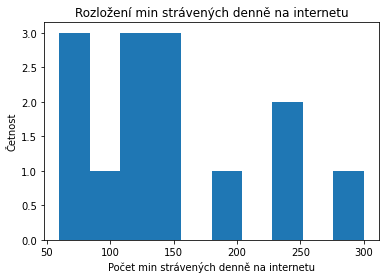

Výběrový průměr: 147.14
Výběrová směrodatná odchylka: 72.34


In [154]:
#podivejme se na vyberovy prumer a smerodatnou odchylku 

plt.hist(int_use.int_use_day_mins)
plt.xlabel("Počet min strávených denně na internetu")
plt.ylabel("Četnost")
plt.title("Rozložení min strávených denně na internetu")
plt.show()

print(f"Výběrový průměr: {int_use.int_use_day_mins.mean().round(2)}")
print(f"Výběrová směrodatná odchylka: {int_use.int_use_day_mins.std().round(2)}")

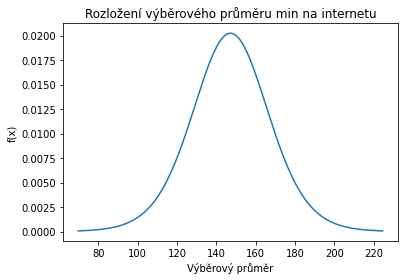

In [155]:
# pojdme si nyni ukázat predpokladane rozlozeni vyberoveho prumeru
prumer = int_use.int_use_day_mins.mean()
smerodatna_chyba = int_use.int_use_day_mins.std() / np.sqrt(int_use.shape[0])
x = np.linspace(prumer - 4*smerodatna_chyba, prumer + 4*smerodatna_chyba, num=10000)
n = int_use.shape[0]
pdf = stats.t.pdf(x, loc = prumer, scale = smerodatna_chyba, df=n-1)

plt.plot(x, pdf)
plt.xlabel("Výběrový průměr")
plt.ylabel("f(x)")
plt.title(f"Rozložení výběrového průměru min na internetu")
plt.show()

U každého statistického testu si zvolíme nějakou kritickou mez, která je určení hladinou pravděpodobnosti $\alpha$. $\alpha$ nám udává pravděpodobnost, že nesprávně zamítneme nulovou hypotézu. Konvenčně se udává hladina $\alpha = 0.05$, ale my si zvolíme nějakou jinou, například $\alpha=0.11$, abychom si ukázali, že tato hladina je do jisté míry arbitrární a záleží na více věcech (jako je síla testu, typ chyby, kterou chcete akceptovat - I.druhu vs II.druhu). Protože t-skór pochází ze studentova t standardního rozložení s $n-1$ stupni volnosti, můžeme ho vypočítat pomocí funkcí, které již známe (stejně jako jsme určovali u intervalů spolehlivosti). Kritická mez bude záležet na typu nulové a alternativní hypotézy. Pojďme si je ukázat.

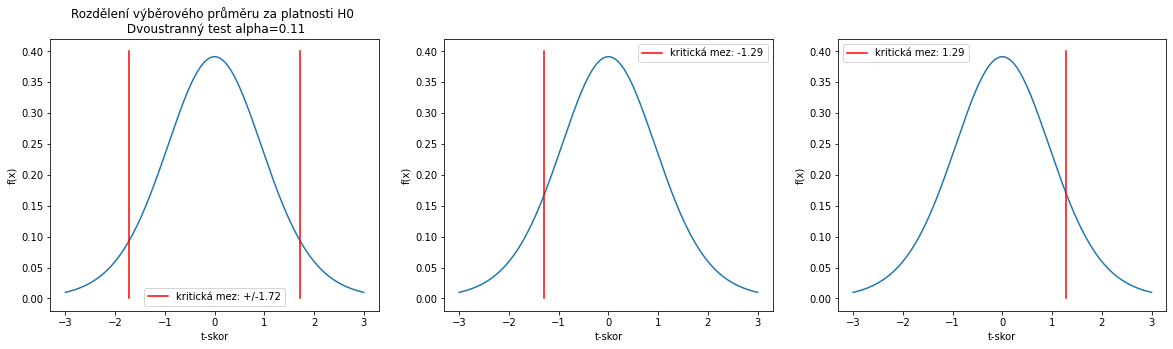

In [156]:
alpha = 0.11
x = np.linspace(-3,3,num=1000)
n = int_use.shape[0]
pdf = stats.t.pdf(x, df=n-1)

# dvoustranny test
t_d = stats.t.ppf(alpha/2, loc = 0, scale = 1, df = n-1)
#levostannny
t_l = stats.t.ppf(alpha, loc = 0, scale = 1, df = n-1)
#pravostranny
t_p = stats.t.ppf(1-alpha, loc = 0, scale = 1, df = n-1)

fig, ax = plt.subplots(1,3,figsize = (20,5))

ax[0].plot(x, pdf)
ax[0].plot([t_d,t_d],[0,0.40], color = "red", label = f"kritická mez: +/{t_d.round(2)}")
ax[0].plot([-1*t_d,-1*t_d],[0,0.40], color = "red")
ax[0].set_xlabel("t-skor")
ax[0].set_ylabel("f(x)")
ax[0].set_title(f"Rozdělení výběrového průměru za platnosti H0 \n Dvoustranný test alpha={alpha}")
ax[0].legend()

ax[1].plot(x, pdf)
ax[1].plot([t_l,t_l],[0,0.40], color = "red", label = f"kritická mez: {t_l.round(2)}")
ax[1].set_xlabel("t-skor")
ax[1].set_ylabel("f(x)")
ax[0].set_title(f"Rozdělení výběrového průměru za platnosti H0 \n Dvoustranný test alpha={alpha}")
ax[1].legend()

ax[2].plot(x, pdf)
ax[2].plot([t_p,t_p],[0,0.40], color = "red", label = f"kritická mez: {t_p.round(2)}")
ax[2].set_xlabel("t-skor")
ax[2].set_ylabel("f(x)")
ax[0].set_title(f"Rozdělení výběrového průměru za platnosti H0 \n Dvoustranný test alpha={alpha}")
ax[2].legend()
plt.show()

Teď, když máme určenou kritickou mez, nám zbývá vypočítat hodnotu testovací statistiky. Jednoduše dosadíme do vzorce $t = \frac{\overline{x} - \mu_0}{\frac{s}{\sqrt{N}}}$

In [157]:
# vypocitat testovaci statistiky
x_hat = int_use.int_use_day_mins.mean()
mu_0 = 180
s = int_use.int_use_day_mins.std()
n = int_use.shape[0]

t = (x_hat - mu_0) / (s / np.sqrt(n))
print(f"Testovací statistika je: {t.round(3)}")

Testovací statistika je: -1.699


Pojďme si testovací statistiku zakreslit do grafu

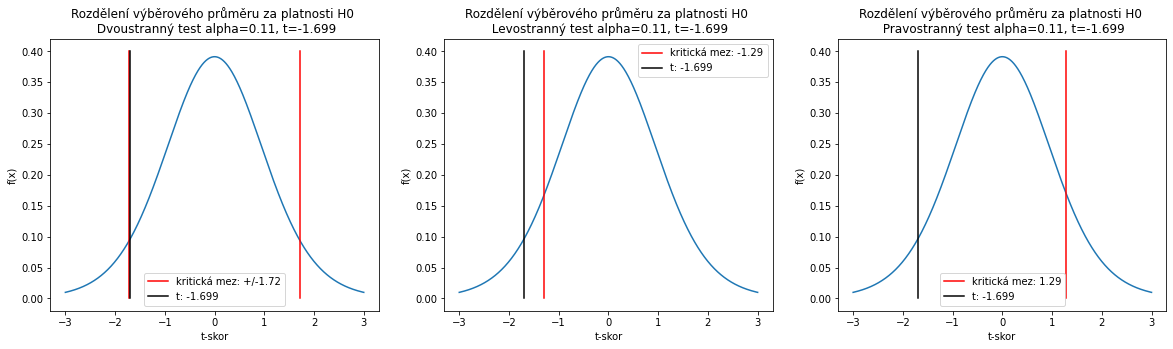

In [158]:
fig, ax = plt.subplots(1,3,figsize = (20,5))

ax[0].plot(x, pdf)
ax[0].plot([t_d,t_d],[0,0.40], color = "red", label = f"kritická mez: +/{t_d.round(2)}")
ax[0].plot([-1*t_d,-1*t_d],[0,0.40], color = "red")
ax[0].plot([t,t], [0, 0.4], color="black", label = f"t: {t.round(3)}")
ax[0].set_xlabel("t-skor")
ax[0].set_ylabel("f(x)")
ax[0].set_title(f"Rozdělení výběrového průměru za platnosti H0 \n Dvoustranný test alpha={alpha}, t={t.round(3)}")
ax[0].legend()

ax[1].plot(x, pdf)
ax[1].plot([t_l,t_l],[0,0.40], color = "red", label = f"kritická mez: {t_l.round(2)}")
ax[1].plot([t,t], [0, 0.4], color="black", label = f"t: {t.round(3)}")
ax[1].set_xlabel("t-skor")
ax[1].set_ylabel("f(x)")
ax[1].set_title(f"Rozdělení výběrového průměru za platnosti H0 \n Levostranný test alpha={alpha}, t={t.round(3)}")
ax[1].legend()

ax[2].plot(x, pdf)
ax[2].plot([t_p,t_p],[0,0.40], color = "red", label = f"kritická mez: {t_p.round(2)}")
ax[2].plot([t,t], [0, 0.4], color="black", label = f"t: {t.round(3)}")
ax[2].set_xlabel("t-skor")
ax[2].set_ylabel("f(x)")
ax[2].set_title(f"Rozdělení výběrového průměru za platnosti H0 \n Pravostranný test alpha={alpha}, t={t.round(3)}")
ax[2].legend()

plt.show()

Při oboustranné hypotéze: $H_0 = 180 $ a tedy $H_1 \neq 180 $, je kritické mez +/- 1.72. Naše testovací statistika má hodnotu -1.699 a není tedy větší než kritické mez. V takovém případě bychom **nezamítali** $H_0$ ve prospěch $H_1$.


Při levostranné hypotéze: $H_0 \ge 180$ a $H_1 < 180$ je kritické mez -1.29. Testovací statistika je menší než tato kritická hodnota a my proto **zamítáme** $H_0$ ve prospěch $H_1$.


Při pravostranné hypotéze: $H_0 \le 180$ a $H_1 > 180$ je kritické mez 1.29. Testovací statistika je menší než tato kritická hodnota a my proto **nezamítáme** $H_0$ ve prospěch $H_1$. 

Abychom si nemuseli stále pamatovat hodnoty kritické meze, které se mohou lišit v závislosti na rozložení výběrové statistiky, používá se tzv p-hodnota, což vyjadřuje pravděpodobnost, že uvidíme pozorovanou hodnotu nebo ještě extrémnějš9 (za předpokladu $H_0$). P-hodnotu můžeme vypočítat jako distribuční funkci (CDF). 

In [159]:
# pro oboustranny test. Musime vynasobit 2 protoze mame kriticke meze na obou strannach rozlozeni
p_h_d = stats.t.cdf(t, df=n-1) * 2

# pro levostrannou hypotezu
p_h_l = stats.t.cdf(t, df=n-1)

# pro pravostrannou hypotezu. Musime odecist od 1 protoze nase kriticka mez je napravo
p_h_p = 1-stats.t.cdf(t, df=n-1)

print(f"P hodnota pro oboustrannou hypotézu je: {p_h_d.round(3)} při chybě I.druhu alpha {alpha}")
print(f"P hodnota pro levostrannou hypotézu je: {p_h_l.round(3)} při chybě I.druhu alpha {alpha}")
print(f"P hodnota pro pravostrannou hypotézu je: {p_h_p.round(3)} při chybě I.druhu alpha {alpha}")

P hodnota pro oboustrannou hypotézu je: 0.113 při chybě I.druhu alpha 0.11
P hodnota pro levostrannou hypotézu je: 0.057 při chybě I.druhu alpha 0.11
P hodnota pro pravostrannou hypotézu je: 0.943 při chybě I.druhu alpha 0.11
